<a href="https://colab.research.google.com/github/mjkimcs/portfolio/blob/main/21b_%EA%B3%BC%EC%A0%81%ED%95%A9%ED%95%B4%EA%B2%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####과적합: train data에 적합하여, 실제 데이터에 대한 오차가 증가하는 문제

![](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)

####과적합 해결방법
1. 교차검증: 트레이닝 데이터를 여러 개의 미니세트로 나누고 이 조각들을 검증용으로 사용  
2. 중요도가 낮은 항목 제거  
3. Early Stopping  
4. 정규화하여 영향을 줄임  
5. 앙상블: 배깅(복잡한 것을 부드럽게), 부스팅(점점 복잡하게)

###import 및 데이터 불러오기

In [ ]:
!pip install eli5
!pip install shap

     |████████████████████████████████| 112kB 7.9MB/s 
     |████████████████████████████████| 358kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489398 sha256=ffcc311f550b0e773dc14ad609e322d0ff643acf42648f5d98b28ee57e751d28
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
pd.set_option('max_columns', None)
import json
import ast
import time
import datetime
import os
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFECV

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier

from sklearn import linear_model
import statsmodels.api as sm

import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv.zip to test.csv.zip
Saving train.csv to train.csv


In [ ]:
!unzip '*.zip'

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.shape

(250, 302)

In [ ]:
test.shape

(19750, 301)

(참고)
#####1. 파일 가져오기  
    from google.colab import files
    uploaded = files.upload()

#####2. 압축풀기
    !unzip '*.zip'


###EDA

In [ ]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,1.359,-0.177,0.406,-0.163,1.341,0.754,0.491,-1.560,-0.520,0.766,0.216,-0.510,0.101,-0.602,-0.721,-0.545,1.564,2.003,-1.940,1.285,-0.987,-1.370,1.373,-0.495,0.113,-0.523,0.053,-0.888,0.249,0.687,1.363,0.169,-1.122,1.209,0.891,0.866,0.847,-1.110,1.224,-1.302,-1.647,-0.091,0.255,0.730,-0.380,0.294,-0.725,0.844,1.002,-1.267,-0.043,1.158,0.779,-0.733,-0.501,1.841,1.459,0.847,1.926,-0.316,0.044,-0.294,0.120,-1.050,0.730,-1.001,-0.321,0.407,0.469,0.445,1.632,0.273,1.557,1.196,-0.548,-0.275,0.179,0.584,-1.873,0.928,0.720,0.885,0.044,-1.131,-1.576,0.616,1.957,-0.518,1.494,1.573,-0.484,0.590,-0.387,0.388,-1.032,-0.841,0.288,-0.230,-2.714,-0.473,0.476,-1.352,-0.922,0.329,-0.558,0.787,-1.043,-0.130,0.517,2.445,0.847,-0.636,-0.324,0.753,0.058,-1.461,-0.820,-0.076,1.127,-0.496,1.020,0.279,0.262,-0.277,-0.166,-0.089,-1.696,-0.598,-0.710,-0.431,0.355,0.966,-1.150,-0.156,0.393,-0.117,0.444,0.948,-0.608,-0.106,-0.491,-0.608,1.565,1.013,-1.391,0.807,-0.607,-0.856,1.230,0.124,-0.336,1.758,-1.649,-1.429,-1.322,-1.501,2.125,-0.572,1.178,-1.451,-0.374,2.386,1.883,0.758,0.295,1.261,-0.837,0.140,-0.183,0.756,0.616,1.371,0.820,-0.702,-1.266,0.496,-0.669,-0.325,-0.170,0.147,-1.134,0.077,1.271,-0.087,-1.431,1.640,0.694,0.949,-2.400,0.657,-0.431,0.124,-0.335,-2.820,0.573,-0.755,3.798,-0.001,0.998,-0.543,1.018,0.883,-1.037,0.513,0.694,0.856,-0.523,0.596,0.971,0.279,2.684,-0.057,-1.754,0.297,-2.196,0.798,-0.533,-0.661,0.564,-2.400,0.945,-0.971,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,1.125,0.279,-0.682,1.161,1.194,0.243,1.179,1.338,-1.000,-0.362,-0.605,1.917,-1.157,0.394,-0.482,1.591,0.106,-0.959,0.600,-1.147,-1.064,3.080,1.057,0.947,-1.125,1.288,-0.171,1.124,-0.454,0.698,-0.028,2.208,0.014,0.872,2.286,-0.822,0.416,1.486,-0.331,-0.993,-0.071,0.543,-0.096,0.041,0.138,1.110,0.692,1.407,-0.234,-1.899,-0.131,0.934,0.802,-1.041,2.004,1.424,0.423,-0.352,-0.656,-0.053,1.036,-1.228,-0.854,-0.748,1.180,0.575,-1.472,-1.215,-0.889,0.004,-0.145,-0.933,-0.713,0.869,0.539,-0.911,-0.638,0.895,-1.896,-0.604,0.312,1.883,-0.292,-0.849,-0.453,0.894,0.339,2.095,0.336,1.290,0.057,-0.159,0.539,0.675,-1.015,-0.304,-1.301,-0.614,-1.176,0.117,0.075,-0.088,1.888,-0.119,0.434,0.135,1.779,0.5

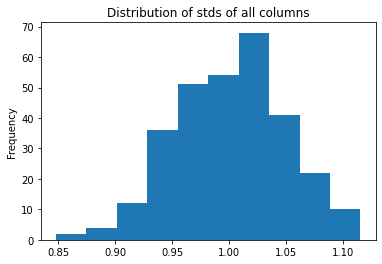

In [ ]:
train[train.columns[2:]].std().plot(kind='hist');
plt.title('Distribution of stds of all columns');

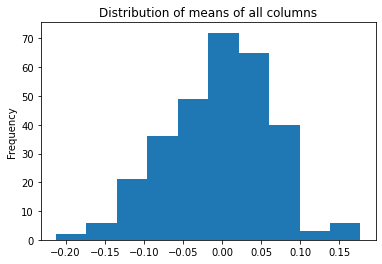

In [ ]:
train[train.columns[2:]].mean().plot(kind='hist');
plt.title('Distribution of means of all columns');

In [ ]:
train.isnull().any().any()

False

Distributions of first 28 columns


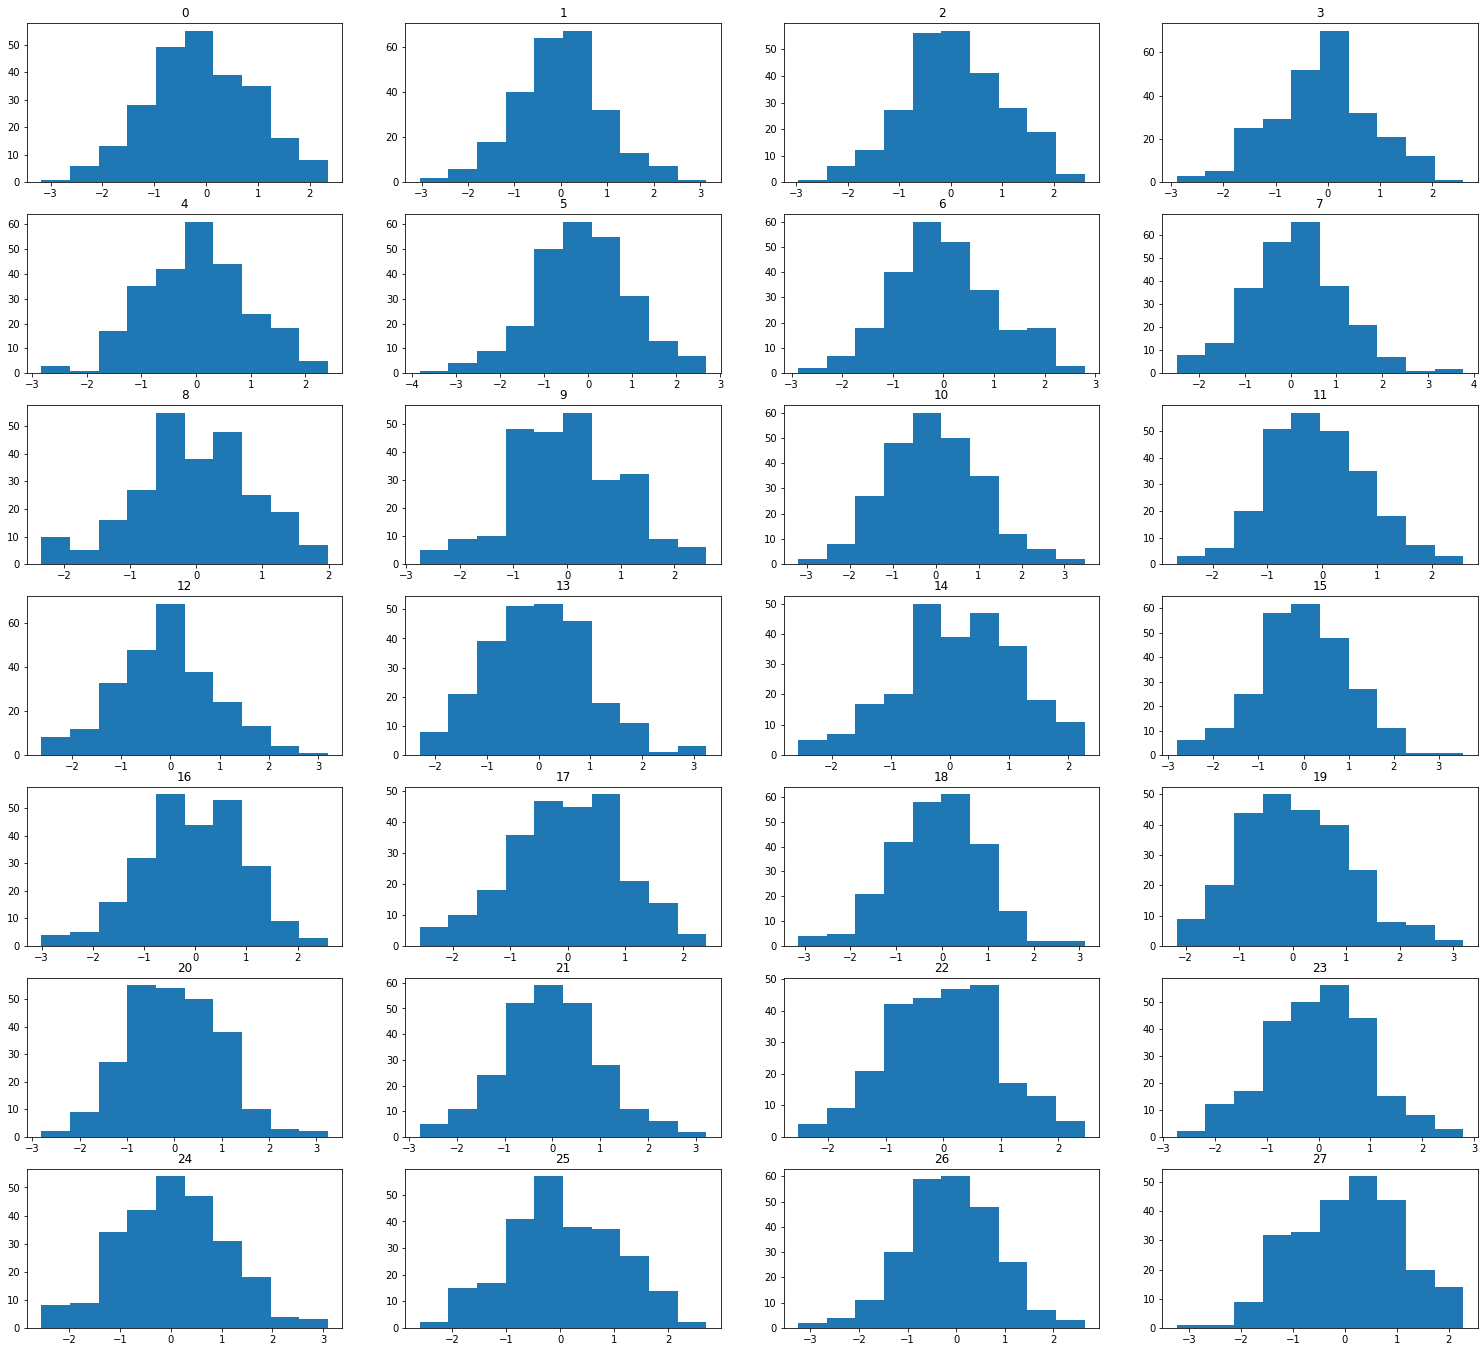

In [ ]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [ ]:
train['target'].value_counts()

0.0    183
1.0     67
Name: target, dtype: int64

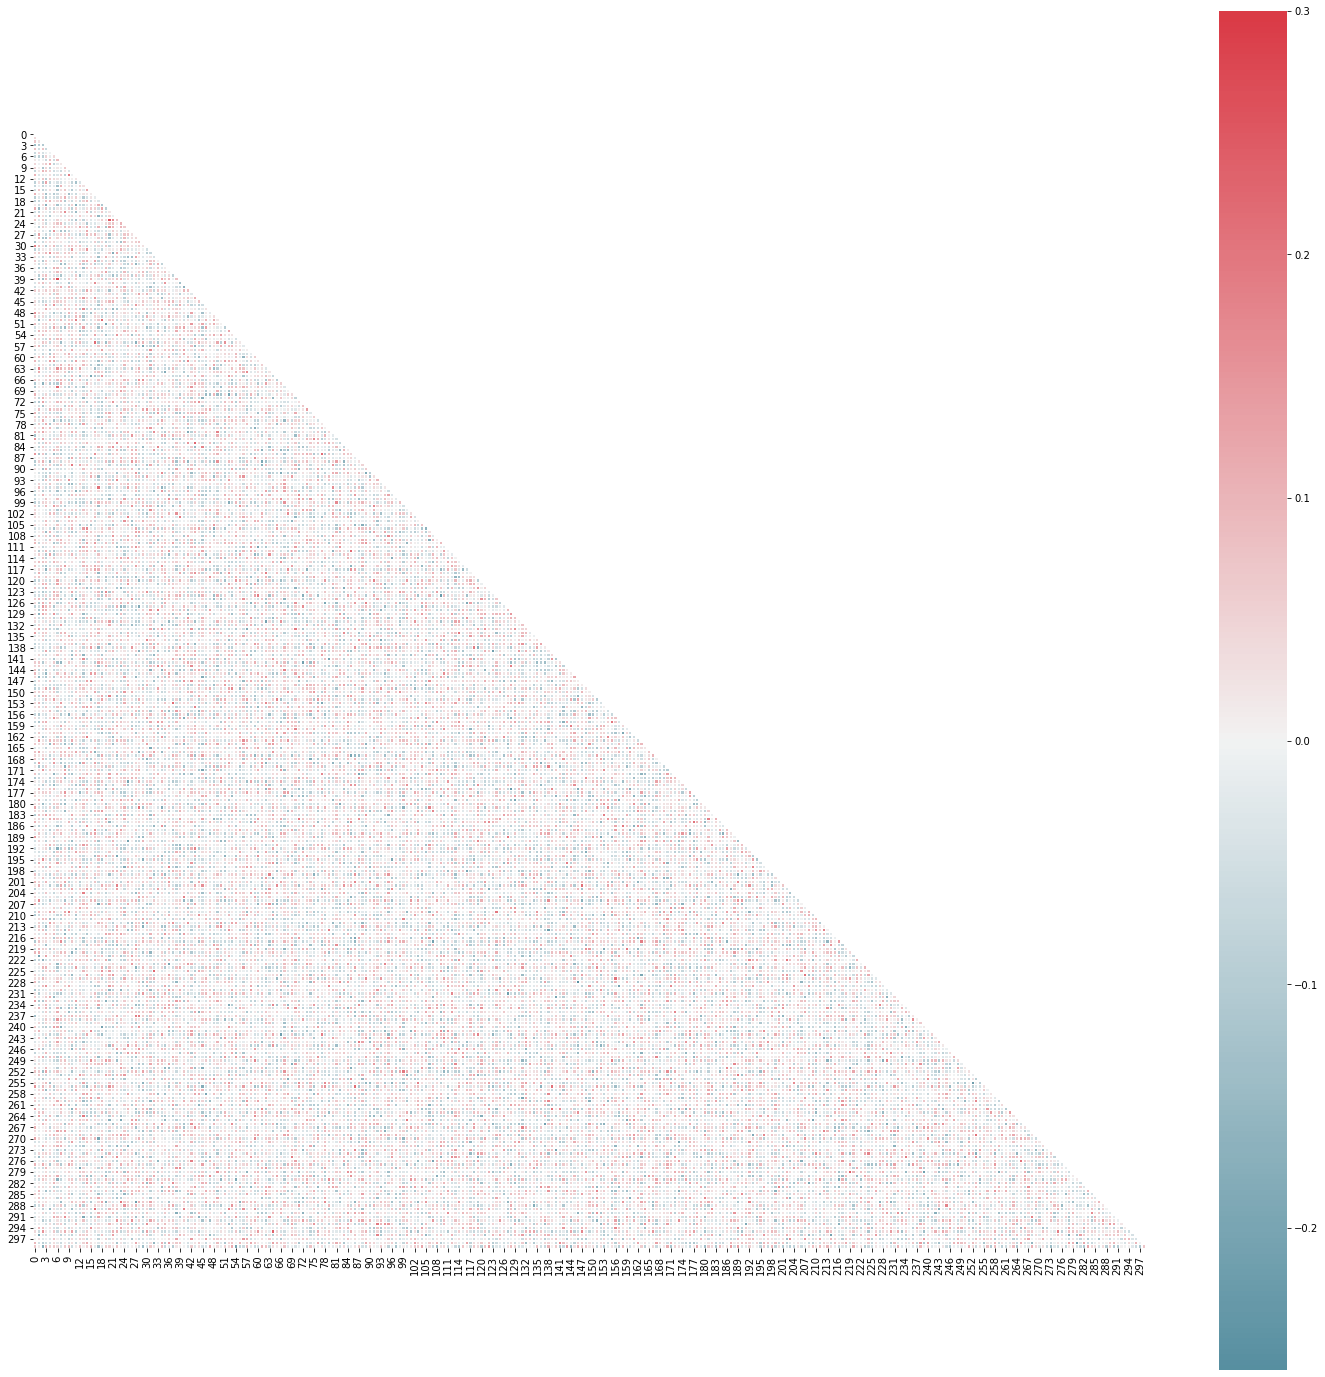

In [ ]:
corr = train[train.columns[2:]].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

In [ ]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,219,279,0.238512
90893,279,219,0.238512
90894,23,20,0.246984
90895,20,23,0.246984
90896,146,228,0.258447
90897,228,146,0.258447
90898,6,39,0.267727
90899,39,6,0.267727
90900,127,target,0.337540
90901,target,127,0.337540


## Basic Modelling

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)

In [ ]:
prediction = np.zeros(len(X_test))
scores_train = []
scores_valid = []
folds = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [ ]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_fold, X_valid_fold = X_train.loc[train_index], X_train.loc[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
    break

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model.fit(X_train_fold, y_train_fold)
y_pred_train = model.predict(X_train_fold).reshape(-1,)
train_score = roc_auc_score(y_train_fold, y_pred_train)

y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
valid_score = roc_auc_score(y_valid_fold, y_pred_valid)

In [ ]:
print(f'Train auc: {train_score:.4}, Valid auc: {valid_score:.4}')

Train auc: 0.8721, Valid auc: 0.7639


In [ ]:
def train_model(X_train, y_train, X_test, folds=folds, model=None):
    prediction = np.zeros(len(X_test))
    scores_train = []
    scores_valid = []
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_train = model.predict(X_train_fold).reshape(-1,)
        train_score = roc_auc_score(y_train_fold, y_pred_train)
        scores_train.append(train_score)
        
        y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
        valid_score = roc_auc_score(y_valid_fold, y_pred_valid)
        scores_valid.append(valid_score)

        y_pred = model.predict_proba(X_test)[:, 1]
        prediction += y_pred

    prediction /= folds.get_n_splits()
    
    print(f'Mean train auc: {np.mean(scores_train):.4f}, std: {np.std(scores_train):.4f}.')
    print(f'Mean valid auc: {np.mean(scores_valid):.4f}, std: {np.std(scores_valid):.4f}.')
    
    return scores_valid, prediction

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds,  model=model)

Mean train auc: 0.8784, std: 0.0105.
Mean valid auc: 0.7153, std: 0.1293.


### Different ways of splitting data into folds
* StratifiedKFold
* RepeatedStratifiedKFold

In [ ]:
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=42)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds, model=model)

Mean train auc: 0.8788, std: 0.0098.
Mean valid auc: 0.7009, std: 0.1438.



### ELI5
ML 모델에 대한 설명을 제공하는 패키지

In [ ]:
eli5.show_weights(model, top=50)

Weight?,Feature
+0.620,x127
+0.226,x18
+0.197,x241
+0.128,x66
+0.101,x213
+0.100,x3
+0.092,x260
+0.089,x178
+0.074,x107
+0.029,x93


In [ ]:
(model.coef_ != 0).sum()

32

In [ ]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]

In [ ]:
for i, coef in enumerate(model.coef_[0]):
    if coef != 0:
        print(f'Feature {X_train.columns[i]} has coefficient {coef:.4f}')

Feature 3 has coefficient 0.0998
Feature 16 has coefficient -0.1017
Feature 18 has coefficient 0.2257
Feature 59 has coefficient -0.1867
Feature 66 has coefficient 0.1285
Feature 69 has coefficient -0.0795
Feature 74 has coefficient -0.1185
Feature 80 has coefficient -0.0625
Feature 93 has coefficient 0.0291
Feature 103 has coefficient 0.0156
Feature 107 has coefficient 0.0744
Feature 113 has coefficient -0.1604
Feature 126 has coefficient -0.1753
Feature 127 has coefficient 0.6198
Feature 133 has coefficient -0.1605
Feature 134 has coefficient -0.0273
Feature 135 has coefficient -0.1899
Feature 159 has coefficient -0.0207
Feature 176 has coefficient -0.2529
Feature 177 has coefficient -0.0438
Feature 178 has coefficient 0.0888
Feature 180 has coefficient 0.0071
Feature 189 has coefficient -0.0521
Feature 199 has coefficient -0.1947
Feature 200 has coefficient -0.1188
Feature 208 has coefficient 0.0223
Feature 211 has coefficient 0.0207
Feature 213 has coefficient 0.1012
Feature 220 ha

In [ ]:
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=model)

Mean train auc: 0.8764, std: 0.0113.
Mean valid auc: 0.7331, std: 0.1403.


<a id="Permutation importance"></a>
### Permutation importance	
* 열 안의 데이터를 무작위로 섞고 점수를 계산
* 점수가 크게 떨어지면 그 항목(열)은 중요하다는 의미


In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds,  model=model)

Mean train auc: 0.8788, std: 0.0098.
Mean valid auc: 0.7009, std: 0.1438.


In [ ]:
submission = pd.read_csv(f'sample_submission.csv')
submission['target'] = prediction
submission.to_csv('overfit_submission1.csv', index=False)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50)

Weight,Feature
0.1240 ± 0.0414,x127
0.0312 ± 0.0217,x18
0.0304 ± 0.0241,x176
0.0288 ± 0.0163,x133
0.0280 ± 0.0134,x200
0.0224 ± 0.0165,x199
0.0184 ± 0.0096,x59
0.0184 ± 0.0367,x113
0.0120 ± 0.0088,x271
0.0096 ± 0.0212,x241


In [ ]:
eli5.formatters.as_dataframe.explain_weights_df(perm).head()

,feature,weight,std
0,x127,0.0880,0.016000
1,x133,0.0232,0.005879
2,x176,0.0192,0.008908
3,x199,0.0168,0.005307
4,x18,0.0112,0.007756


In [ ]:
eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0].shape

(33, 3)

In [ ]:
selected_weights = eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0]

In [ ]:
top_features = [i[1:] for i in selected_weights.feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=model)

Mean train auc: 0.8763, std: 0.0115.
Mean valid auc: 0.7344, std: 0.1406.


### SHAP: 항목이 예측에 미치는 영향 파악하기
* 행: 항목	
* 빨간색: 긍정적인 영향, 1
* 파란색: 부정적인 영향, 0		


In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds, model=model)

Mean train auc: 0.8788, std: 0.0098.
Mean valid auc: 0.7009, std: 0.1438.


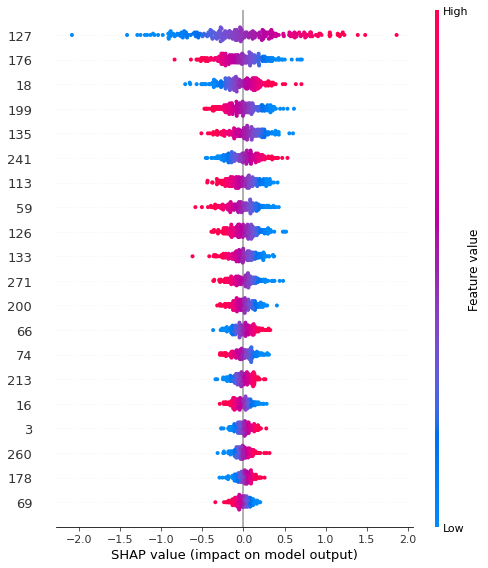

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### Recursive feature elimination



In [ ]:
def train_model_with_feature_selection(X_train, y_train, X_test, folds=folds, model=None, feature_selector=None):
    prediction = np.zeros(len(X_test))
    scores_train = []
    scores_valid = []
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        # so that we don't transform the original test data
        X_test_copy = X_test.copy()
        
        feature_selector.fit(X_train_fold, y_train_fold)
        X_train_fold = feature_selector.transform(X_train_fold)
        X_valid_fold = feature_selector.transform(X_valid_fold)
        X_test_copy = feature_selector.transform(X_test_copy)
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_train = model.predict(X_train_fold).reshape(-1,)
        train_score = roc_auc_score(y_train_fold, y_pred_train)
        scores_train.append(train_score)
        
        y_pred_valid = model.predict(X_valid_fold).reshape(-1,)
        valid_score = roc_auc_score(y_valid_fold, y_pred_valid)
        scores_valid.append(valid_score)

        y_pred = model.predict_proba(X_test_copy)[:, 1]
        prediction += y_pred

    prediction /= folds.get_n_splits()
    
    print(f'Mean train auc: {np.mean(scores_train):.4f}, std: {np.std(scores_train):.4f}.')
    print(f'Mean valid auc: {np.mean(scores_valid):.4f}, std: {np.std(scores_valid):.4f}.')
    
    return scores_valid, prediction


In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
feature_selector = RFECV(model, min_features_to_select=10, scoring='roc_auc', step=0.1, verbose=0, cv=repeated_folds, n_jobs=-1)
scores, prediction = train_model_with_feature_selection(X_train.values, y_train, X_test, folds=repeated_folds, model=model, feature_selector=feature_selector)

Mean train auc: 0.8759, std: 0.0167.
Mean valid auc: 0.6993, std: 0.1467.


## Comparing models

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.8784, std: 0.0105.
Mean valid auc: 0.7153, std: 0.1293.

Best score of GridSearchCV: 0.931574074074074
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Mean train auc: 0.9346, std: 0.0068.
Mean valid auc: 0.8692, std: 0.1035.


In [ ]:
model = AdaBoostClassifier()
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]


abc = AdaBoostClassifier()

parameter_grid = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

grid_search = GridSearchCV(abc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_abc, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 1.0000, std: 0.0000.
Mean valid auc: 0.5526, std: 0.1483.

Best score of GridSearchCV: 0.6804629629629629
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}

Mean train auc: 0.9652, std: 0.0191.
Mean valid auc: 0.5701, std: 0.1127.


In [ ]:
model = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001, loss='modified_huber')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

parameter_grid = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01, 0.1, 0.5],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_sgd, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.9950, std: 0.0063.
Mean valid auc: 0.5972, std: 0.1423.

Best score of GridSearchCV: 0.7864814814814816
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.15, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'penalty': 'l1'}

Mean train auc: 0.8386, std: 0.0172.
Mean valid auc: 0.6303, std: 0.1468.


In [ ]:
model = SVC(probability=True, gamma='scale')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
selected_weights = eli5.formatters.as_dataframe.explain_weights_df(perm).loc[eli5.formatters.as_dataframe.explain_weights_df(perm)['weight'] != 0]
top_features = [i[1:] for i in selected_weights.feature if 'BIAS' not in i]
X_train_selected = train[top_features]
y_train = train['target']
X_test_selected = test[top_features]

svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_svc, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.9674, std: 0.0087.
Mean valid auc: 0.5000, std: 0.0000.

Best score of GridSearchCV: 0.7088888888888889
Best parameters: {'C': 10.0, 'kernel': 'rbf'}

Mean train auc: 1.0000, std: 0.0000.
Mean valid auc: 0.5029, std: 0.0507.


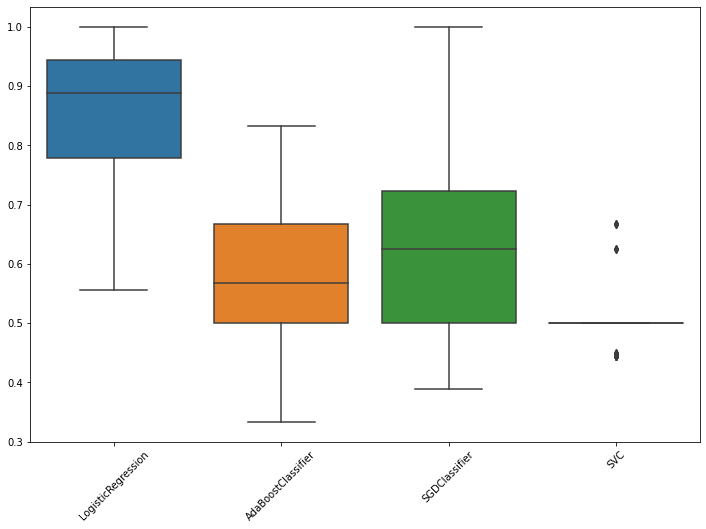

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores_logreg})
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['SGDClassifier'] = scores_sgd
scores_df['SVC'] = scores_svc

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

## Feature engineering

In [ ]:
X_train['mean'] = X_train.mean(axis=1)
X_train['kurt'] = X_train.kurt(axis=1)
X_train['mad'] = X_train.mad(axis=1)
X_train['median'] = X_train.median(axis=1)
X_train['max'] = X_train.max(axis=1)
X_train['min'] = X_train.min(axis=1)
X_train['skew'] = X_train.skew(axis=1)
X_train['sem'] = X_train.sem(axis=1)

X_test['mean'] = X_test.mean(axis=1)
X_test['kurt'] = X_test.kurt(axis=1)
X_test['mad'] = X_test.mad(axis=1)
X_test['median'] = X_test.median(axis=1)
X_test['max'] = X_test.max(axis=1)
X_test['min'] = X_test.min(axis=1)
X_test['skew'] = X_test.skew(axis=1)
X_test['sem'] = X_test.sem(axis=1)

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = itemgetter([int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i])(X_train.columns)
X_train_selected = X_train[top_features]
y_train = train['target']
X_test_selected = X_test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.8928, std: 0.0089.
Mean valid auc: 0.7019, std: 0.1691.

Best score of GridSearchCV: 0.9427777777777777
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Mean train auc: 0.9428, std: 0.0093.
Mean valid auc: 0.8511, std: 0.1231.


## Scaling the data

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)

In [ ]:
sc = StandardScaler()
data = StandardScaler().fit_transform(np.concatenate((X_train, X_test), axis=0))
X_train.iloc[:, :] = data[:250]
X_test.iloc[:, :] = data[250:]

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
print('Default scores')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=folds, model=model)
print()
top_features = itemgetter([int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i])(X_train.columns)
X_train_selected = X_train[top_features]
y_train = train['target']
X_test_selected = X_test[top_features]

lr = linear_model.LogisticRegression(max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.05, 0.08, 0.01, 0.1, 1.0, 10.0],
                  'solver': ['liblinear']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print(f'Best score of GridSearchCV: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')

print()
scores_logreg, prediction = train_model(X_train_selected.values, y_train, X_test_selected, folds=repeated_folds, model=grid_search.best_estimator_)

Default scores
Mean train auc: 0.8786, std: 0.0106.
Mean valid auc: 0.7069, std: 0.1438.

Best score of GridSearchCV: 0.9255555555555557
Best parameters: {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Mean train auc: 0.9288, std: 0.0065.
Mean valid auc: 0.8643, std: 0.1070.


In [ ]:
submission = pd.read_csv(f'sample_submission.csv')
submission['target'] = prediction
submission.to_csv('overfit_submission2.csv', index=False)